In [1]:
from collections import defaultdict

import os
from glob import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

# 1. EDA from Annotation file

In [2]:
traindata_dir = "./data/train"
traindata_ann_file = "./data/train.csv"

testdata_dir = "./data/test"
testdata_ann_file = "./data/test.csv"

In [3]:
train_data = pd.read_csv(traindata_ann_file)
test_data = pd.read_csv(testdata_ann_file)

In [4]:
# train ann file은 15021개의 행과 (class_name, image_path, target) 3개의 열로 이루어짐
train_data.info(), train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  15021 non-null  object
 1   image_path  15021 non-null  object
 2   target      15021 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 352.2+ KB


(None,
   class_name                image_path  target
 0  n01872401  n01872401/sketch_50.JPEG      59
 1  n02417914  n02417914/sketch_11.JPEG     202
 2  n02106166   n02106166/sketch_3.JPEG     138
 3  n04235860   n04235860/sketch_2.JPEG     382
 4  n02056570  n02056570/sketch_40.JPEG      80)

In [5]:
# test ann file은 10014개의 행과 1개의 열로 이루어짐 (image_path)
test_data.info(), test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10014 non-null  object
dtypes: object(1)
memory usage: 78.4+ KB


(None,
   image_path
 0     0.JPEG
 1     1.JPEG
 2     2.JPEG
 3     3.JPEG
 4     4.JPEG)

In [6]:
# 데이터의 기본적인 통계 정보
train_data.describe(include="all")

,class_name,image_path,target
count,15021,15021,15021.000000
unique,500,15021,NaN
top,n04004767,n01688243/sketch_31.JPEG,NaN
freq,31,1,NaN
mean,NaN,NaN,249.989082
std,NaN,NaN,144.471752
min,NaN,NaN,0.000000
25%,NaN,NaN,125.000000
50%,NaN,NaN,250.000000
75%,NaN,NaN,375.000000


In [7]:
# class_name, target은 총 500개의 클래스로 이루어짐 (target: 0~499)
train_data["class_name"].nunique(), train_data["target"].nunique()

(500, 500)

각 클래스별(target 별) count 분포

/tmp/ipykernel_645230/1004645359.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(train_data["target"], bins=500, kde=False, palette="viridis")


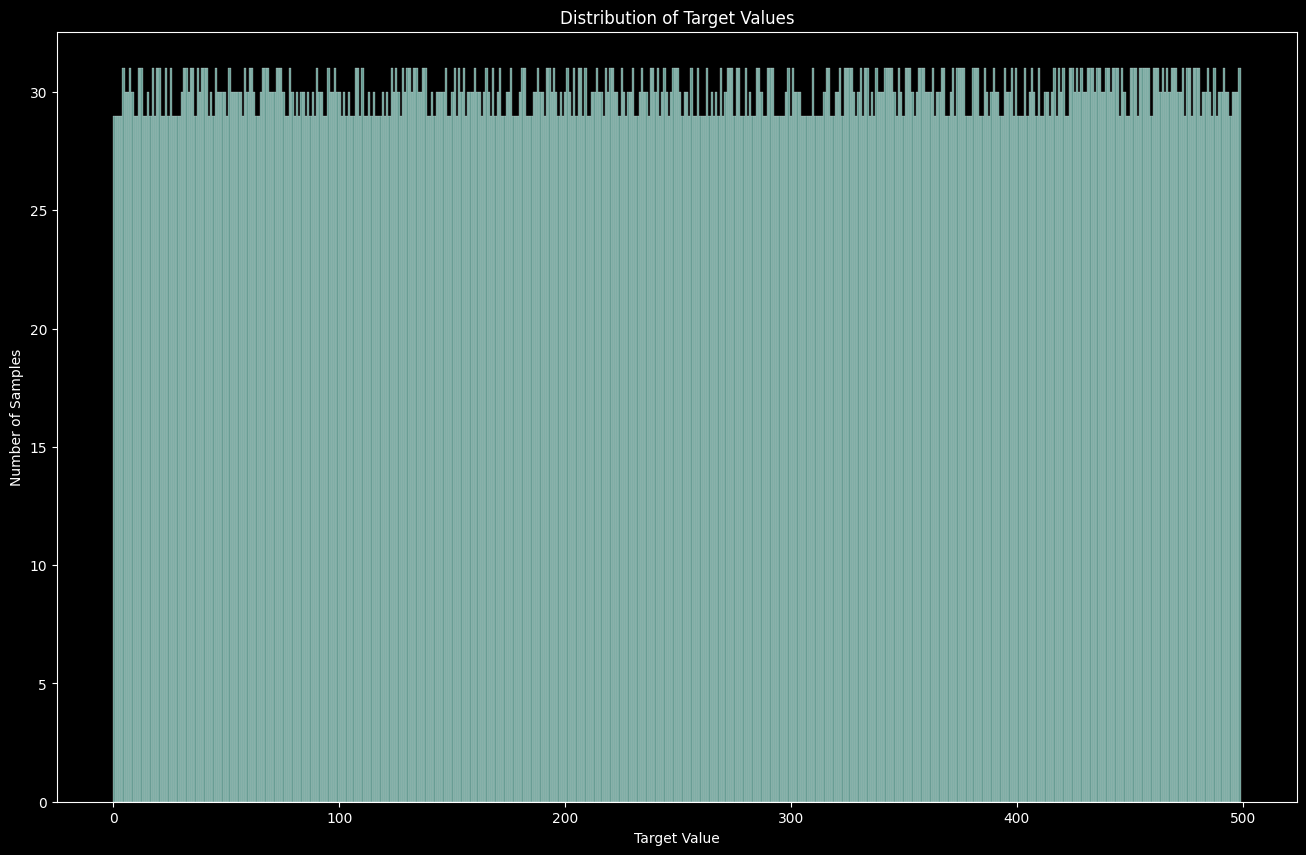

In [8]:
plt.style.use('dark_background')

plt.figure(figsize=(16, 10))
sns.histplot(train_data["target"], bins=500, kde=False, palette="viridis")
plt.title("Distribution of Target Values")
plt.xlabel("Target Value")
plt.ylabel("Number of Samples")

plt.show()

# 2. EDA from Image files

In [9]:
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")

print(f"number of train images: {len(train_images)}")
print(f"number of test images: {len(test_images)}")

number of train images: 15021
number of test images: 10014


In [10]:
# 이미지를 읽어 메타 정보를 ann file dataframe에 병합하는 과정
image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    with Image.open(path) as img:
        image_prop["height"].append(img.height)
        image_prop["width"].append(img.width)
        image_prop["img_aspect_ratio"] = img.width / img.height
        image_prop["mode"].append(img.mode)
        image_prop["format"].append(img.format)
        image_prop["size"].append(round(os.path.getsize(path) /1e6, 2))
    image_prop["path"].append(path)
    image_prop["image_path"].append(
        path.split("/")[-2] + "/" + path.split("/")[-1]
    )

image_data = pd.DataFrame(image_prop)
image_data = image_data.merge(train_data, on="image_path")

In [11]:
image_data

,height,width,img_aspect_ratio,mode,format,size,path,image_path,class_name,target
0,494,800,0.664414,RGB,JPEG,0.04,./data/train/n02814533/sketch_47.JPEG,n02814533/sketch_47.JPEG,n02814533,241
1,615,800,0.664414,L,JPEG,0.07,./data/train/n02814533/sketch_10.JPEG,n02814533/sketch_10.JPEG,n02814533,241
2,225,420,0.664414,RGB,JPEG,0.05,./data/train/n02814533/sketch_48.JPEG,n02814533/sketch_48.JPEG,n02814533,241
3,495,660,0.664414,RGB,JPEG,0.07,./data/train/n02814533/sketch_13.JPEG,n02814533/sketch_13.JPEG,n02814533,241
4,494,800,0.664414,RGB,JPEG,0.04,./data/train/n02814533/sketch_36.JPEG,n02814533/sketch_36.JPEG,n02814533,241
...,...,...,...,...,...,...,...,...,...,...
15016,640,640,0.664414,RGB,JPEG,0.14,./data/train/n02091134/sketch_18.JPEG,n02091134/sketch_18.JPEG,n02091134,100
15017,586,482,0.664414,L,JPEG,0.10,./data/train/n02091134/sketch_32.JPEG,n02091134/sketch_32.JPEG,n02091134,100
15018,480,640,0.664414,RGB,JPEG,0.10,./data/train/n02091134/sketch_25.JPEG,n02091134/sketch_25.JPEG,n02091134,100
15019,750,416,0.664414,RGB,JPEG,0.04,./data/train/n02091134/sketch_49.JPEG,n02091134/sketch_49.JPEG,n02091134,100


In [12]:
# 이미지 특징 추출 (RGB)
def extract_image_features(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            width, height = img.size
            img_array = np.array(img)
            mean_red = np.mean(img_array[:, :, 0])
            mean_green = np.mean(img_array[:, :, 1])
            mean_blue = np.mean(img_array[:, :, 2])

            format = image_path.split(".")[-1].upper()
            return (
                width, height, img.mode, format, os.path.getsize(image_path),
                mean_red, mean_green, mean_blue
                )
    except Exception as e:
        return (
            None
        ) * 8

In [13]:
image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    width, height, mode, format, size, mean_red, mean_green, mean_blue = extract_image_features(path)
    image_prop['height'].append(height)
    image_prop['width'].append(width)
    image_prop['mode'].append(mode)
    image_prop['format'].append(format)
    image_prop['size'].append(round(size / 1e6, 2) if size else None)
    image_prop['mean_red'].append(mean_red)
    image_prop['mean_green'].append(mean_green)
    image_prop['mean_blue'].append(mean_blue)
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])

image_data = pd.DataFrame(image_prop)
image_data['img_aspect_ratio'] = image_data['width'] / image_data['height']

image_data = image_data.merge(train_data, on='image_path')
image_data.sort_values(by='target', inplace=True)

In [14]:
image_data.head()

,height,width,mode,format,size,mean_red,mean_green,mean_blue,path,image_path,img_aspect_ratio,class_name,target
8618,700,700,RGB,JPEG,0.07,235.520600,235.549143,235.100276,./data/train/n01443537/sketch_26.JPEG,n01443537/sketch_26.JPEG,1.000000,n01443537,0
8619,470,450,RGB,JPEG,0.09,235.501073,235.501073,235.501073,./data/train/n01443537/sketch_12.JPEG,n01443537/sketch_12.JPEG,0.957447,n01443537,0
8617,470,450,RGB,JPEG,0.05,236.729040,236.729040,236.729040,./data/train/n01443537/sketch_15.JPEG,n01443537/sketch_15.JPEG,0.957447,n01443537,0
8620,800,800,RGB,JPEG,0.05,245.134653,245.134653,245.134653,./data/train/n01443537/sketch_35.JPEG,n01443537/sketch_35.JPEG,1.000000,n01443537,0
8611,590,678,RGB,JPEG,0.12,223.690270,223.698983,223.685376,./data/train/n01443537/sketch_11.JPEG,n01443537/sketch_11.JPEG,1.149153,n01443537,0


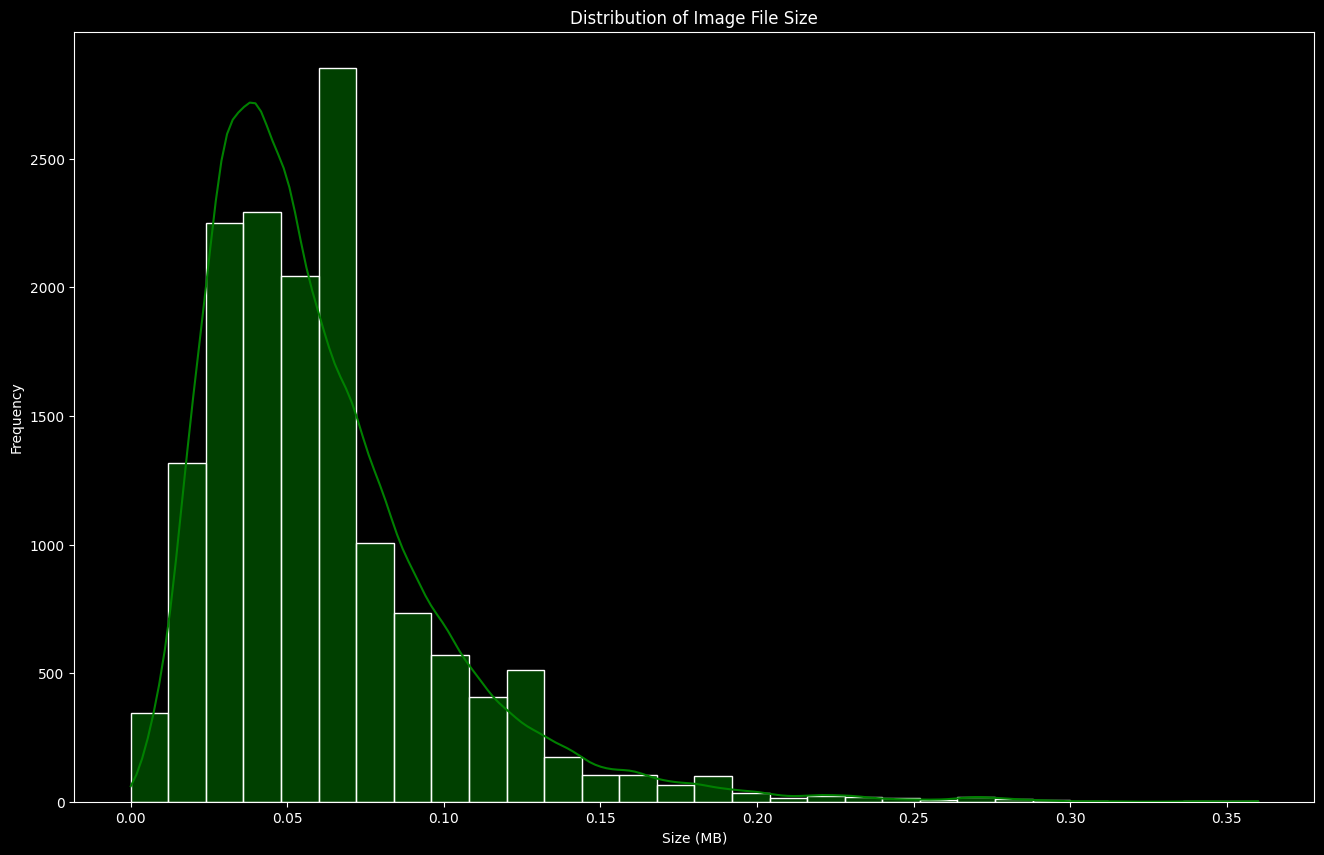

In [15]:
# file size

plt.figure(figsize=(16, 10))
sns.histplot(image_data["size"], bins=30, kde=True, color="green")
plt.title("Distribution of Image File Size")
plt.xlabel("Size (MB)")
plt.ylabel("Frequency")

plt.show()

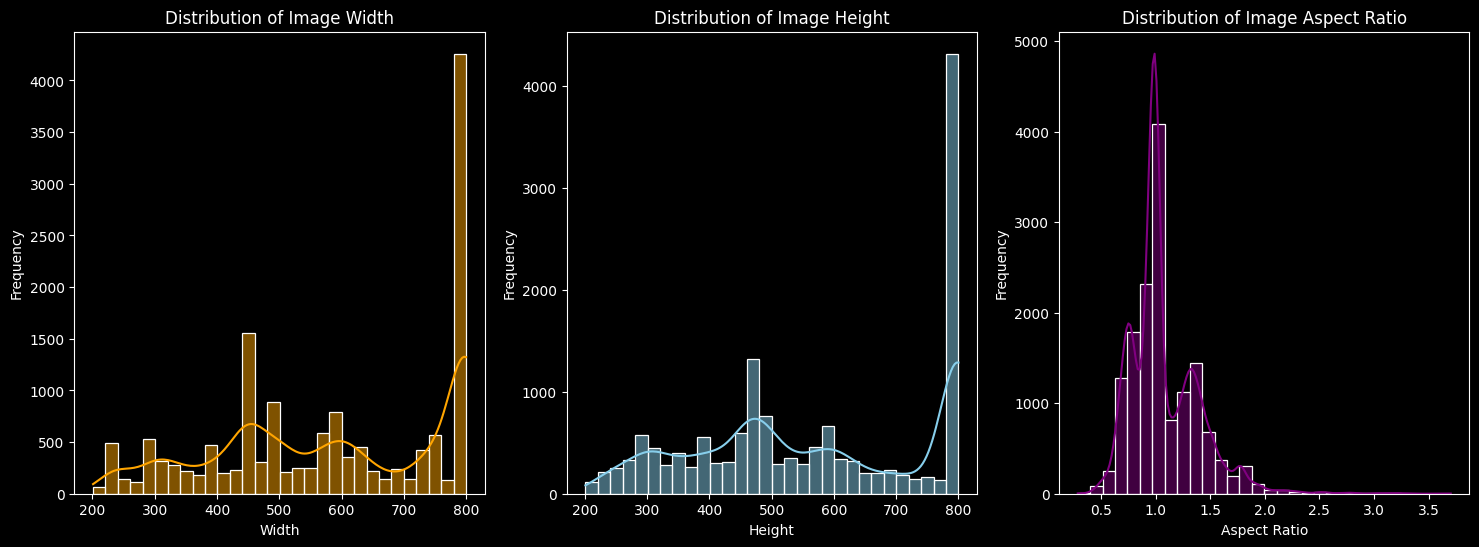

In [16]:
# width, height, width / height
plt.figure(figsize=(18, 6))

# width
plt.subplot(1, 3, 1)
sns.histplot(image_data["width"], bins=30, kde=True, color="orange")
plt.title("Distribution of Image Width")
plt.xlabel("Width")
plt.ylabel("Frequency")

# height
plt.subplot(1, 3, 2)
sns.histplot(image_data["height"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Image Height")
plt.xlabel("Height")
plt.ylabel("Frequency")

# width / height
plt.subplot(1, 3, 3)
sns.histplot(image_data["img_aspect_ratio"], bins=30, kde=True, color="purple")
plt.title("Distribution of Image Aspect Ratio")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")

plt.show()


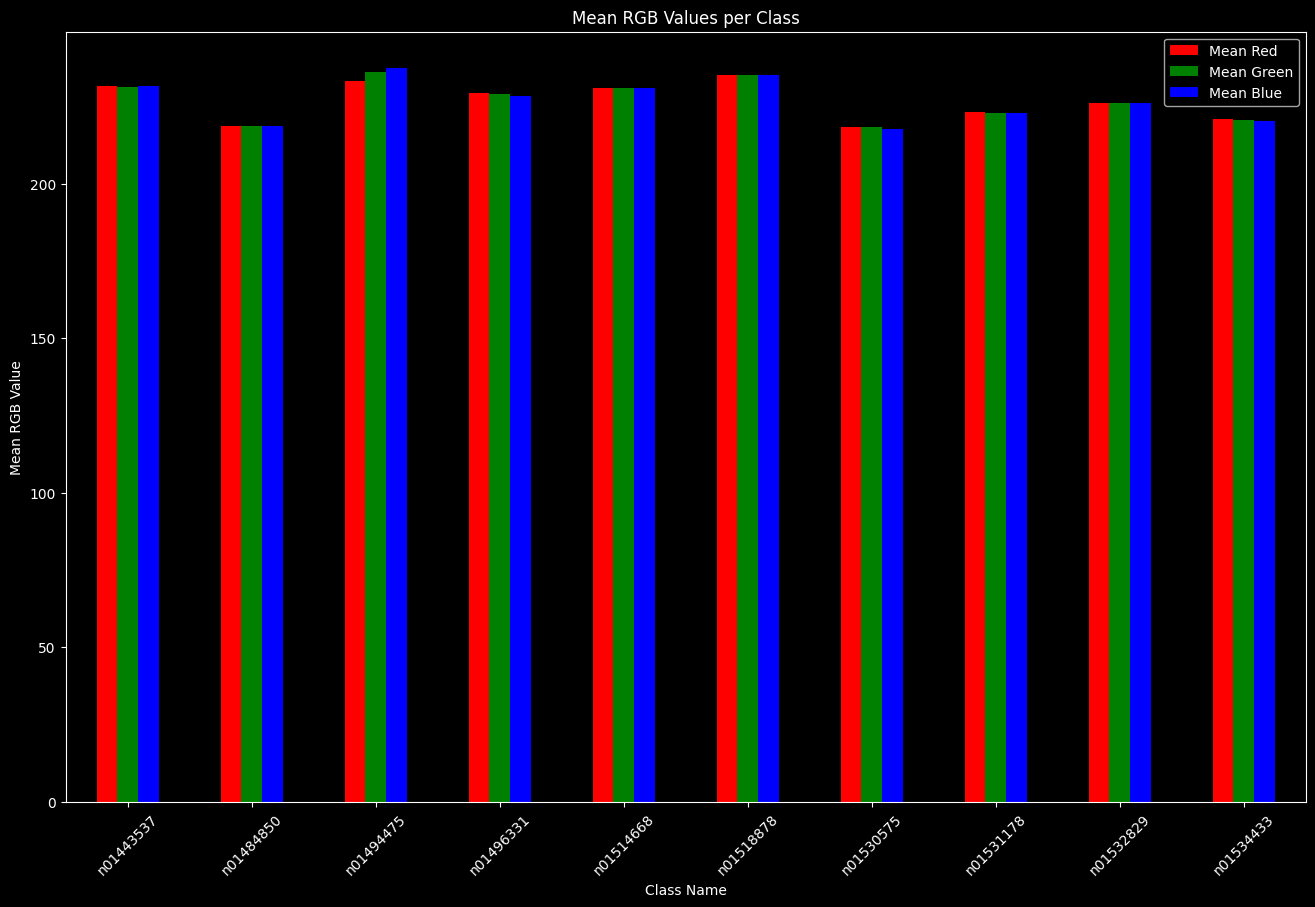

In [17]:
# 클래스 10개 sample RGB 평균 값
sample_classes = image_data["class_name"].unique()[:10]

mean_rgb_per_class = image_data[image_data["class_name"].isin(sample_classes)] \
    .groupby("class_name")[["mean_red", "mean_green", "mean_blue"]].mean()

mean_rgb_per_class.plot(kind="bar", figsize=(16, 10), color=["red", "green", "blue"])
plt.title("Mean RGB Values per Class")
plt.xlabel("Class Name")
plt.ylabel("Mean RGB Value")
plt.xticks(rotation=45)
plt.legend(["Mean Red", "Mean Green", "Mean Blue"])
plt.show()

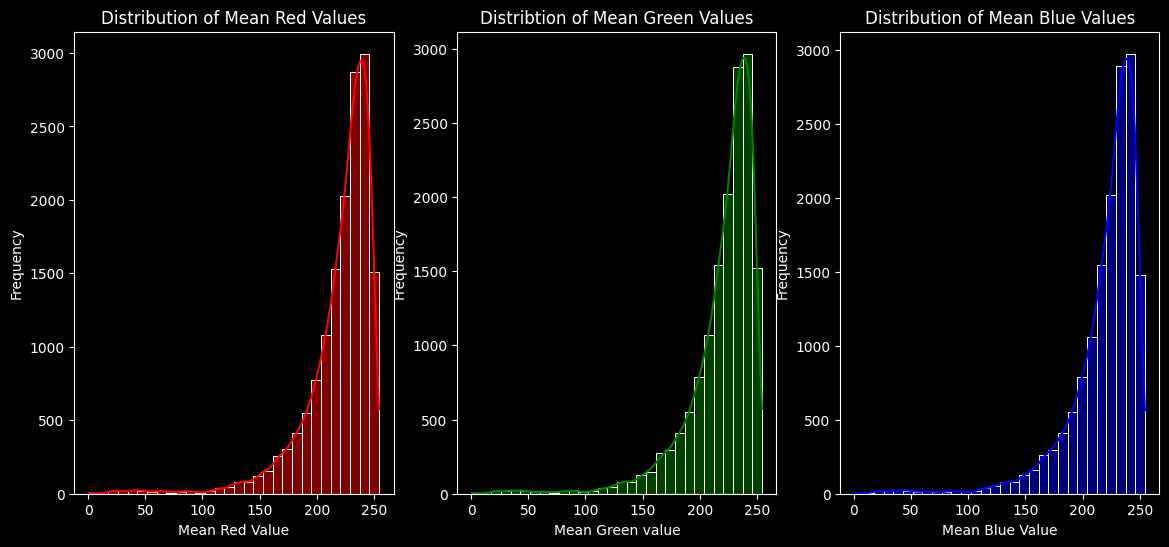

In [18]:
plt.figure(figsize=(14, 6))

# mean_red 분포
plt.subplot(1, 3, 1)
sns.histplot(image_data["mean_red"], bins=30, kde=True, color="red")
plt.title("Distribution of Mean Red Values")
plt.xlabel("Mean Red Value")
plt.ylabel("Frequency")

# mean_green 분포
plt.subplot(1, 3, 2)
sns.histplot(image_data["mean_green"], bins=30, kde=True, color="green")
plt.title("Distribtion of Mean Green Values")
plt.xlabel("Mean Green value")
plt.ylabel("Frequency")

# mean_blue 분포
plt.subplot(1, 3, 3)
sns.histplot(image_data["mean_blue"], bins=30, kde=True, color="blue")
plt.title("Distribution of Mean Blue Values")
plt.xlabel("Mean Blue Value")
plt.ylabel("Frequency")

plt.show()

대부분의 R, G, B값이 200~250에 분포 -> 전반적으로 이미지의 밝기와 채도가 높다.

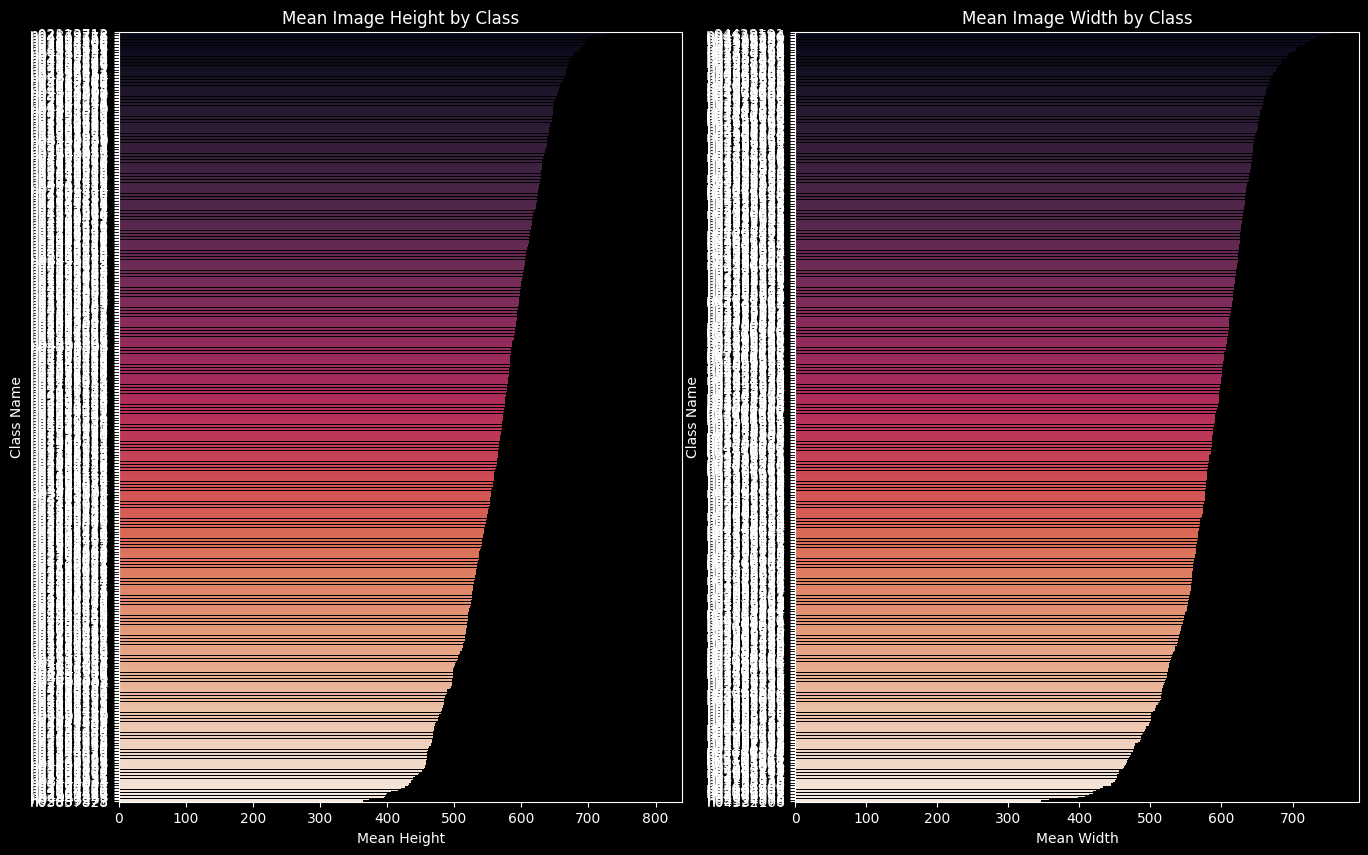

In [19]:
sns.set_palette(sns.color_palette("rocket"))

# 클래스별 이미지의 평균 높이 너비 계산
class_size_stats = image_data.groupby("class_name")[["height", "width"]].mean().reset_index()

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.barplot(
    x="height", y="class_name", hue="class_name",
    data=class_size_stats.sort_values(by="height", ascending=False),
    palette="rocket"
    )
plt.title("Mean Image Height by Class")
plt.xlabel("Mean Height")
plt.ylabel("Class Name")

plt.subplot(1, 2, 2)
sns.barplot(
    x="width", y="class_name", hue="class_name",
    data=class_size_stats.sort_values(by="width", ascending=False),
    palette="rocket"
)
plt.title("Mean Image Width by Class")
plt.xlabel("Mean Width")
plt.ylabel("Class Name")

plt.show()

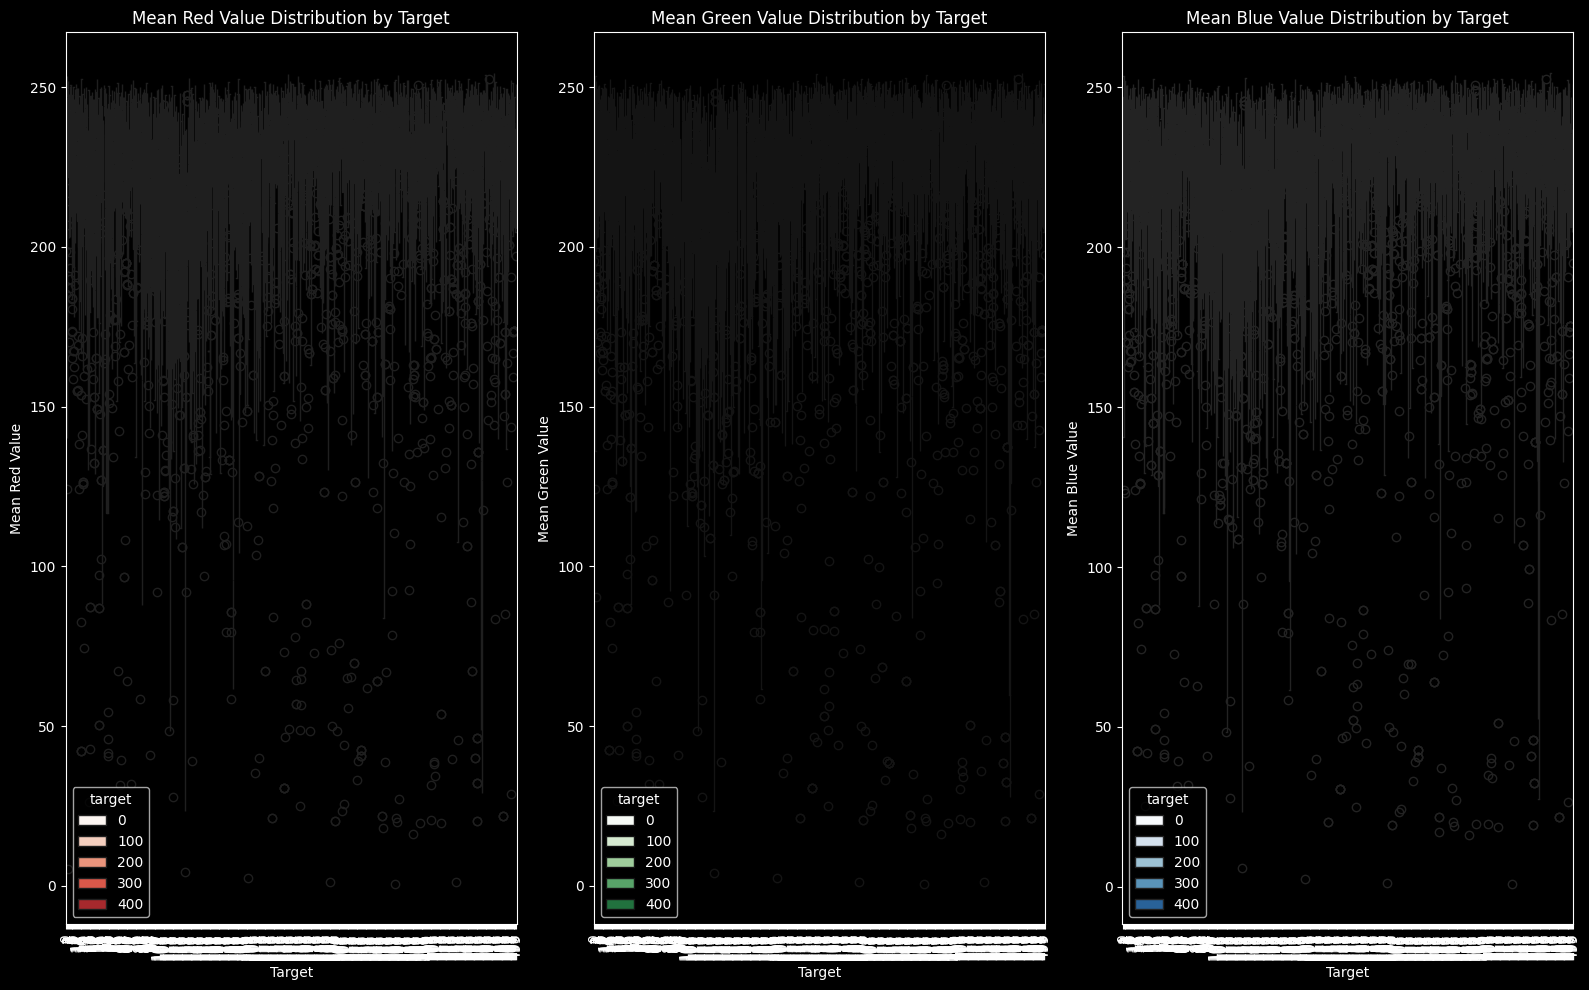

In [20]:
plt.figure(figsize=(16, 10))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='mean_red', hue="target", data=image_data, palette='Reds')
plt.title('Mean Red Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Red Value')
plt.xticks(rotation=90)

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='mean_green', hue="target", data=image_data, palette='Greens')
plt.title('Mean Green Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Green Value')
plt.xticks(rotation=90)

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='mean_blue', hue="target", data=image_data, palette='Blues')
plt.title('Mean Blue Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Blue Value')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


# 이미지 샘플 확인

images: ['./data/train/n01534433/sketch_43.JPEG'
 './data/train/n01534433/sketch_50.JPEG'
 './data/train/n01534433/sketch_18.JPEG'
 './data/train/n01534433/sketch_14.JPEG'
 './data/train/n01534433/sketch_15.JPEG'
 './data/train/n01534433/sketch_34.JPEG'
 './data/train/n01534433/sketch_26.JPEG'
 './data/train/n01534433/sketch_20.JPEG'
 './data/train/n01534433/sketch_9.JPEG'
 './data/train/n01534433/sketch_35.JPEG'
 './data/train/n01534433/sketch_40.JPEG'
 './data/train/n01534433/sketch_17.JPEG'
 './data/train/n01534433/sketch_6.JPEG'
 './data/train/n01534433/sketch_5.JPEG'
 './data/train/n01534433/sketch_38.JPEG'
 './data/train/n01534433/sketch_19.JPEG'
 './data/train/n01534433/sketch_36.JPEG'
 './data/train/n01534433/sketch_44.JPEG'
 './data/train/n01534433/sketch_25.JPEG'
 './data/train/n01534433/sketch_42.JPEG'
 './data/train/n01534433/sketch_7.JPEG'
 './data/train/n01534433/sketch_41.JPEG'
 './data/train/n01534433/sketch_1.JPEG'
 './data/train/n01534433/sketch_2.JPEG'
 './data/train

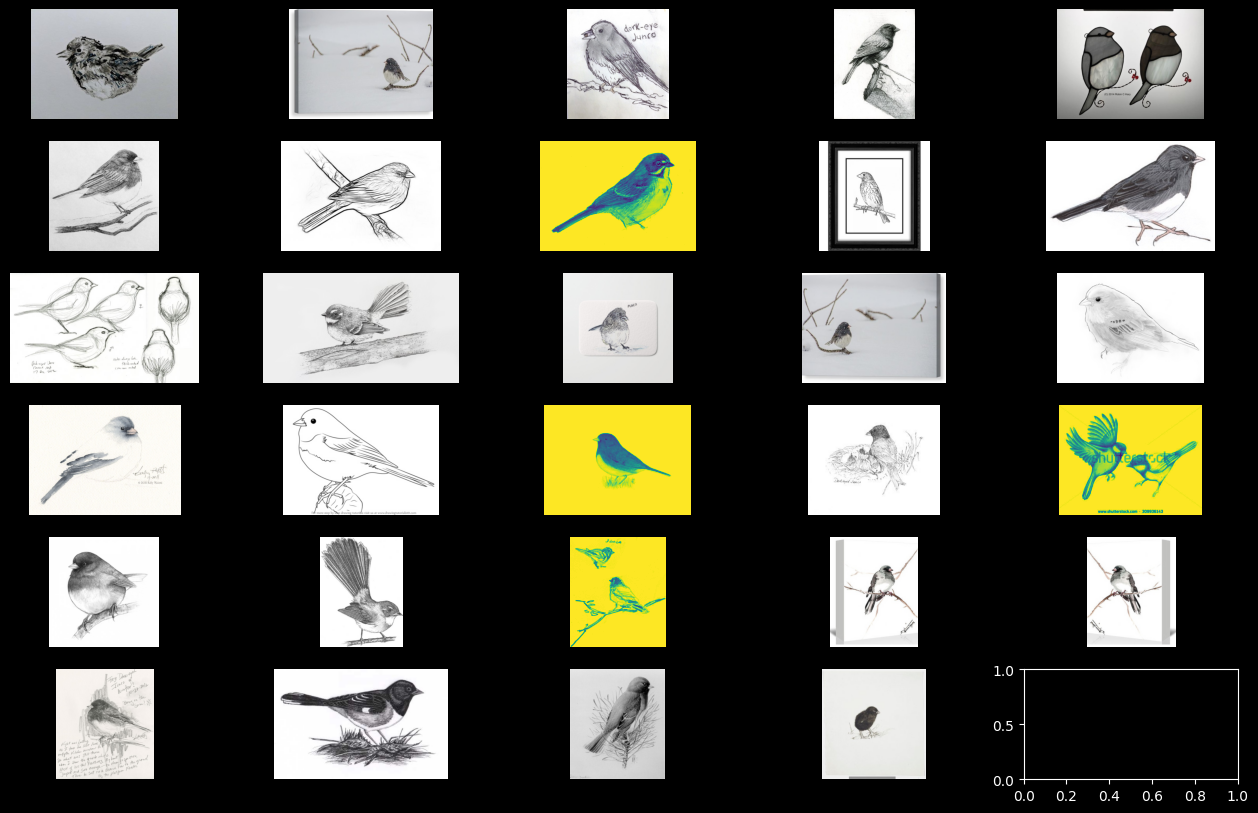

In [23]:
def displaying_images(data, target):
    length = len(data[data["target"] == target])
    fig, axs = plt.subplots((length // 5) + 1, 5, figsize=(16, 10))
    images = data[data["target"] == target]["path"].values
    print(f"images: {images}")

    for i, path in enumerate(images):
        img = Image.open(path)
        ax = axs[i // 5, i % 5]
        ax.imshow(img)
        ax.axis("off")
    plt.show()

displaying_images(image_data, target=9)

   height  width mode format  size   mean_red  mean_green  mean_blue  \
0     494    800  RGB   JPEG  0.04  30.630423   30.630423  30.630423   

                                    path                image_path  \
0  ./data/train/n02814533/sketch_47.JPEG  n02814533/sketch_47.JPEG   

   img_aspect_ratio class_name  target  
0          1.619433  n02814533     241  


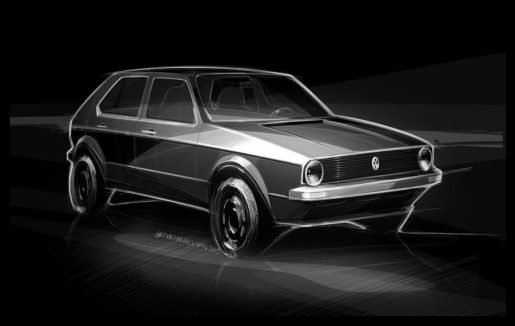

In [27]:
import matplotlib.image as mpimg

img_pth = train_images[0]
selected_img = image_data[image_data["path"] == img_pth]
print(selected_img)

img = mpimg.imread(img_pth)
plt.imshow(img)
plt.axis("off")
plt.show()

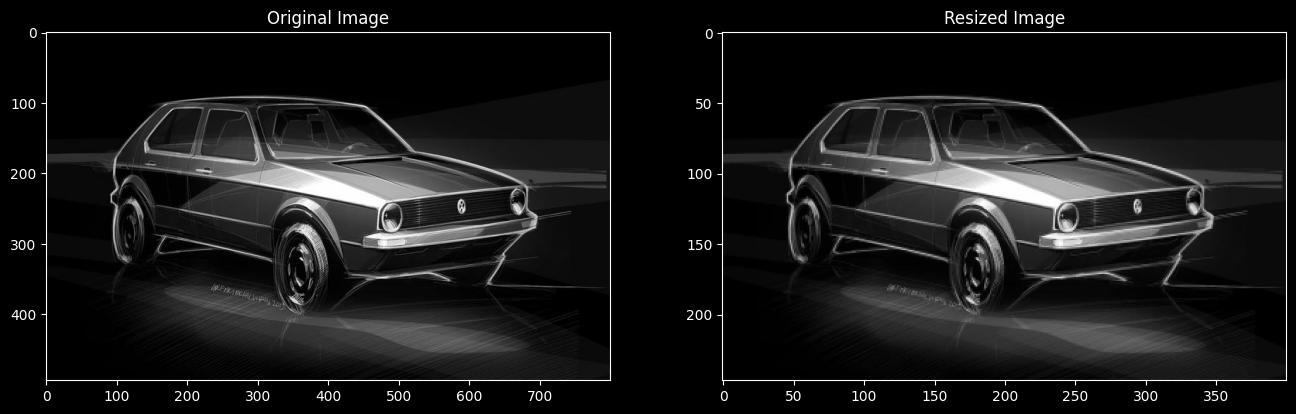

In [28]:
img = cv2.imread(img_pth, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].imshow(resized_img)
ax[1].set_title("Resized Image")
plt.show()